# Mining Software Repositories(MSR) 2025 - Mining Challenge

# Reaserch Question #2 (RQ2)

**How can we assess and identify high-risk clusters of artifacts using a composite risk score derived from various risk metrics?**

### Risk factors to consider

* **Total CVEs per Cluster:**
* **Average CVE Severity Score (1-4 scale: LOW=1, MODERATE=2, HIGH=3, CRITICAL=4):**
* **Average Time Since Last Update:**
* **Average Freshness Score in Days:**
* **Average Popularity Score:**
* **Average Release Interval in Days:**
* **Calculated Risk Score (From above metrics)**


# Graph Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import os
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime

In [90]:
from neo4j import GraphDatabase

#connect to the database
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Password1"))

In [92]:
def execute_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return result.data()

In [94]:
gds_version = """
CALL gds.version()
"""
print(execute_query(gds_version))

[{'gdsVersion': '2.6.8'}]


## Goblin Weaver

**NOTE:** Used goblin weaver to update the AddedValues in the Database. Getting updated CVE information from the Open Source Vulnerability (OSV) database. Running Weaver does the following.

* **Automatic Deletion:** Automatically deletes the CVE entries from the neo4J data. Leaves FRESHNESS, POPULARITY_1_YEAR, SPEED as they are internal data.

**Goblin Weaver Not Used** The database came with added metrics that were current up through 8/30/20204. This will be good enough for my analysis. 
I found that when trying to use the goblin weaver, it deleted my CVE from added values with the idea that it would be added back by querying updated databases at OSV. I had a hard time getting the weaver to add values back.

## Added Value Nodes

### Verify AddedValues Nodes Exist

In [14]:
# Fetch all node property keys from the database
verify_nodes_query = """
MATCH (n) 
RETURN DISTINCT labels(n) AS nodeLabels
"""
result = execute_query(verify_nodes_query)
print(f"Nodes Available: {result}")

Nodes Available: [{'nodeLabels': ['Artifact']}, {'nodeLabels': ['Release']}, {'nodeLabels': ['AddedValue']}]


### Find AddedValue Properties

In [16]:
test_AV_query = """
MATCH (n:AddedValue)
RETURN keys(n) AS properties, COUNT(*) AS count
LIMIT 1
    """
results = execute_query(test_AV_query)
results

[{'properties': ['value', 'id', 'type'], 'count': 28772855}]

### Find the Possible Types

In [19]:
test_AV_query = """
MATCH (n:AddedValue)
RETURN DISTINCT n.type AS types
    """
results = execute_query(test_AV_query)
results

[{'types': 'CVE'},
 {'types': 'FRESHNESS'},
 {'types': 'POPULARITY_1_YEAR'},
 {'types': 'SPEED'}]

### Find One Artifact/Release That Has a CVE Property

In [22]:
# Helper function to clean and unescape the JSON string
def clean_json_string(json_str):
    # Remove the escaping of quotes if necessary (unescape the string)
    json_str = json_str.replace('\\"', '"')
    
    # Remove additional escaping if present (optional based on your data)
    json_str = re.sub(r'\\+', '', json_str)
    
    return json_str

In [24]:
cve_node = """
MATCH (a:Artifact)-[rel]-(r:Release)-[rel2]-(av:AddedValue)
WHERE av.type='CVE' AND av.value CONTAINS 'CVE-'
RETURN a.id AS artifact_id, r.id AS release_id, av.id AS added_value_id, av.value AS cve_value
LIMIT 1
"""

results = execute_query(cve_node)

# Process the results
data = []
for record in results:
    cve_value = record['cve_value']

    try:
        # Clean the JSON string before parsing
        cleaned_cve_value = clean_json_string(cve_value)
        
        # Attempt to parse the cleaned cve_value JSON string
        cve_data = json.loads(cleaned_cve_value)

        # Extract relevant information from the cve_data (if available)
        cve_entry = cve_data.get("cve", [])[0]  # Assuming we are interested in the first CVE entry
        cwe = cve_entry.get('cwe', 'N/A')       # Extract CWE
        severity = cve_entry.get('severity', 'N/A')  # Extract severity
        cve_name = cve_entry.get('name', 'N/A')  # Extract CVE name

    except (json.JSONDecodeError, IndexError, KeyError) as e:
        # Handle and log JSON parsing errors or missing fields
        print(f"Error parsing JSON for record: {cve_value}, Error: {e}")
        cwe = 'N/A'
        severity = 'N/A'
        cve_name = 'N/A'

    # Append the processed data to the list
    data.append({
        'Artifact ID': record['artifact_id'],
        'Release ID': record['release_id'],
        'Added Value ID': record['added_value_id'],
        'CVE Name': cve_name,
        'CWE': cwe,
        'Severity': severity
    })

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    

   Artifact ID                              Release ID  \
0  junit:junit  org.keycloak:keycloak-core:3.4.1.Final   

                               Added Value ID        CVE Name        CWE  \
0  org.keycloak:keycloak-core:3.4.1.Final:CVE  CVE-2019-10170  [CWE-267]   

  Severity  
0     HIGH  


# Risk Metrics

## CVE

Total number of known vulnerabilities associated with the artifacts in each cluster. This is a direct measure of potential security risks.  
* Identify the artifacts and their releases in each cluster
* Cross-reference these artifacts with a CVE database.
* Sum the CVEs for each cluster

### Retrieve CVE Data for All Relevant Artifacts

In [155]:
cve_node_query = """
MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]->(av:AddedValue)
WHERE av.type = 'CVE' AND av.value CONTAINS 'CVE-'
RETURN a.id AS artifact_id, r.id AS release_id, av.id AS added_value_id, av.value AS cve_value, a.communityId AS communityId
"""

results = execute_query(cve_node_query)


### Clean and Parse JSON

In [157]:
def clean_json_string(json_str):
    # Remove any unwanted characters or patterns
    cleaned_str = json_str.replace('\\', '')
    cleaned_str = re.sub(r'"\s*{\s*"', '{"', cleaned_str)
    cleaned_str = re.sub(r'"\s*}\s*"', '"}', cleaned_str)
    return cleaned_str

In [160]:
data = []
for record in results:
    cve_value = record['cve_value']

    try:
        # Clean and parse the JSON string
        cleaned_cve_value = clean_json_string(cve_value)
        cve_data = json.loads(cleaned_cve_value)

        # Extract relevant information from the cve_data
        cve_entries = cve_data.get("cve", [])
        for cve_entry in cve_entries:
            cwe = cve_entry.get('cwe', 'N/A')
            severity = cve_entry.get('severity', 'N/A')
            cve_name = cve_entry.get('name', 'N/A')

            # Append the processed data to the list
            data.append({
                'Artifact ID': record['artifact_id'],
                'Release ID': record['release_id'],
                'Added Value ID': record['added_value_id'],
                'CVE Name': cve_name,
                'CWE': cwe,
                'Severity': severity,
                'Community ID': record['communityId']
            })

    except (json.JSONDecodeError, IndexError, KeyError, TypeError) as e:
        # Handle and log JSON parsing errors or missing fields
        print(f"Error parsing JSON for record: {cve_value}, Error: {e}")
        # Optionally, append incomplete data or skip
        continue

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Export
df.to_csv('CVE_data.csv', index=False)

In [162]:
print(df.head(5))

                  Artifact ID                              Release ID  \
0  org.keycloak:keycloak-core  org.keycloak:keycloak-core:3.4.1.Final   
1  org.keycloak:keycloak-core  org.keycloak:keycloak-core:3.4.1.Final   
2  org.keycloak:keycloak-core  org.keycloak:keycloak-core:3.4.1.Final   
3  org.keycloak:keycloak-core  org.keycloak:keycloak-core:3.4.1.Final   
4  org.keycloak:keycloak-core  org.keycloak:keycloak-core:3.4.1.Final   

                               Added Value ID        CVE Name  \
0  org.keycloak:keycloak-core:3.4.1.Final:CVE  CVE-2019-10170   
1  org.keycloak:keycloak-core:3.4.1.Final:CVE   CVE-2022-0225   
2  org.keycloak:keycloak-core:3.4.1.Final:CVE   CVE-2020-1697   
3  org.keycloak:keycloak-core:3.4.1.Final:CVE  CVE-2019-14837   
4  org.keycloak:keycloak-core:3.4.1.Final:CVE  CVE-2021-20262   

                 CWE  Severity  Community ID  
0          [CWE-267]      HIGH         10471  
1           [CWE-79]  MODERATE         10471  
2           [CWE-79]  MODERAT

### Associate CVE Data with Clusters

In [168]:
# Group the CVE data by 'Community ID'
cve_by_cluster = df.groupby('Community ID')

# Calculate the total number of CVEs per cluster
total_cves_per_cluster = cve_by_cluster['CVE Name'].count().reset_index()
total_cves_per_cluster = total_cves_per_cluster.rename(columns={'CVE Name': 'Total CVEs'})

# Calculate the total number of unique releases per cluster as this is what the CVE is tied to.
num_artifacts_per_cluster = df.groupby('Community ID')['Release ID'].nunique().reset_index()
num_artifacts_per_cluster = num_artifacts_per_cluster.rename(columns={'Release ID': 'Num_Releases'})

# List all CVEs per cluster
cves_list_per_cluster = cve_by_cluster['CVE Name'].apply(list).reset_index()
cves_list_per_cluster = cves_list_per_cluster.rename(columns={'CVE Name': 'CVE List'})

# Merge the total CVEs, CVE lists, and number of artifacts
cluster_cve_data = pd.merge(total_cves_per_cluster, cves_list_per_cluster, on='Community ID')
cluster_cve_data = pd.merge(cluster_cve_data, num_artifacts_per_cluster, on='Community ID')

# Export
cluster_cve_data.to_csv('cluster_cve_data.csv', index=False)

# Display the merged data
print("CVE Data per Cluster:")
print(cluster_cve_data.head())



CVE Data per Cluster:
   Community ID  Total CVEs  \
0           436         121   
1           657         401   
2          1434          10   
3          2682          28   
4          2702          30   

                                            CVE List  Num_Releases  
0  [CVE-2022-25873, CVE-2022-25873, CVE-2022-2587...           121  
1  [CVE-2021-32013, CVE-2021-32012, CVE-2021-3201...           171  
2  [CVE-2017-3200, CVE-2017-3200, CVE-2017-3200, ...            10  
3  [CVE-2016-9177, CVE-2018-9159, CVE-2016-9177, ...            18  
4  [CVE-2023-33546, CVE-2023-33546, CVE-2023-3354...            30  


### Calculate CVE Metrics per Cluster

**Verify Severity Scores Exist**

In [172]:
severity_levels = df['Severity'].unique()

print("Different Severity Levels Present in the Data:")
print(severity_levels)

Different Severity Levels Present in the Data:
['HIGH' 'MODERATE' 'CRITICAL' 'LOW' 'UNKNOWN']


**Convert Severity Levels to Numerical Scores**

In [175]:
severity_mapping = {
    'LOW': 1,
    'MODERATE': 2,
    'HIGH': 3,
    'CRITICAL': 4,
    'UNKNOWN': 0
}

# Map the severity levels to numerical scores
df['Severity Score'] = df['Severity'].map(severity_mapping)


**Handle Missing Severity Scores**

In [178]:
# Replace any missing severity scores with 0 or an appropriate default
df['Severity Score'] = df['Severity Score'].fillna(0)


**Calculate Average Severity per Cluster**

In [194]:
# Calculate the average severity score per cluster
average_severity_score_per_cluster = df.groupby('Community ID')['Severity Score'].mean().reset_index()
average_severity_score_per_cluster = average_severity_score_per_cluster.rename(columns={'Severity Score': 'Average Severity Score'})

# Merge the average severity score into the existing cluster_cve_data DataFrame
cluster_cve_data = pd.merge(cluster_cve_data, average_severity_score_per_cluster, on='Community ID', how='left')

# Export the updated DataFrame to a CSV file
cluster_cve_data.to_csv('cluster_cve_data.csv', index=False)

# Display the updated DataFrame
print("Updated Cluster CVE Data with Average Severity Score:")
print(cluster_cve_data.head())



Updated Cluster CVE Data with Average Severity Score:
   Community ID  Total CVEs  \
0           436         121   
1           657         401   
2          1434          10   
3          2682          28   
4          2702          30   

                                            CVE List  Num_Releases  \
0  [CVE-2022-25873, CVE-2022-25873, CVE-2022-2587...           121   
1  [CVE-2021-32013, CVE-2021-32012, CVE-2021-3201...           171   
2  [CVE-2017-3200, CVE-2017-3200, CVE-2017-3200, ...            10   
3  [CVE-2016-9177, CVE-2018-9159, CVE-2016-9177, ...            18   
4  [CVE-2023-33546, CVE-2023-33546, CVE-2023-3354...            30   

   Average Severity Score  
0                2.000000  
1                2.349127  
2                3.000000  
3                2.357143  
4                2.000000  


**Normalize the Total CVEs**  
Number of CVEs per release (on average) per cluster

In [203]:
# Add the normalized Total CVEs as a new column
cluster_cve_data['Normalized Total CVEs'] = (
    cluster_cve_data['Total CVEs'] / cluster_cve_data['Num_Releases']
)

# Export the updated DataFrame to a CSV file
cluster_cve_data.to_csv('cluster_cve_data.csv', index=False)



**Display the Metrics**

In [206]:
print(cluster_cve_data.sort_values(by='Average Severity Score', ascending=False).head(20))


     Community ID  Total CVEs  \
75          36717           6   
79          39037           4   
25          11504          53   
59          30752           6   
121         57273           4   
127         61493          15   
101         50022           9   
50          27120           3   
97          46633           8   
81          39418          31   
135         65986           5   
87          41352           3   
122         58239          11   
54          28969        2270   
34          16657         107   
136         66039           5   
82          39655         998   
130         62299          27   
118         56718           4   
112         53957          45   

                                              CVE List  Num_Releases  \
75   [CVE-2020-17531, CVE-2020-17531, CVE-2020-1753...             6   
79   [CVE-2023-51084, CVE-2023-51084, CVE-2023-5108...             4   
25   [CVE-2023-27162, CVE-2023-27162, CVE-2023-2716...            53   
59   [CVE-2021-430

In [208]:
# Count the number of CVEs per severity level
severity_counts = df['Severity'].value_counts()

print("Number of CVEs per Severity Level:")
print(severity_counts)

Number of CVEs per Severity Level:
Severity
HIGH        67235
MODERATE    61643
CRITICAL    32304
LOW          8008
UNKNOWN         3
Name: count, dtype: int64


**Visualizing Severity Distributions**

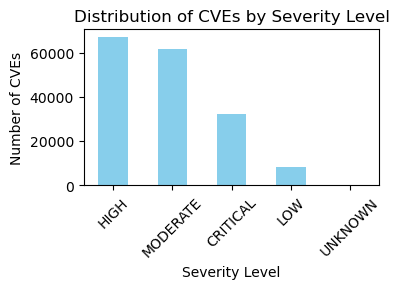

In [211]:
# Plot the number of CVEs per severity level
plt.figure(figsize=(4, 3))
severity_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Severity Level')
plt.ylabel('Number of CVEs')
plt.title('Distribution of CVEs by Severity Level')
plt.xticks(rotation=45)
plt.tight_layout()

# Export Plot
plt.savefig('cve_severity_distribution.pdf', bbox_inches='tight')

# Display
plt.show()

**Create Cluster_Risk_Metrics External File**

In [213]:
cluster_risk_metrics = cluster_cve_data

In [215]:
# Save the DataFrame to a Pickle file (more efficient for large data)
cluster_risk_metrics.to_pickle('cluster_cve_metrics.pkl')
print("Data saved to 'cluster_cve_metrics.pkl'")

Data saved to 'cluster_cve_metrics.pkl'


**Load pickle file for verification**

In [218]:
# Load the DataFrame from the pickle file
cluster_risk_metrics = pd.read_pickle('cluster_cve_metrics.pkl')

print("DataFrame loaded from 'cluster_cve_metrics.pkl'")

# Print the first few lines of the DataFrame
print(cluster_risk_metrics.head())

DataFrame loaded from 'cluster_cve_metrics.pkl'
   Community ID  Total CVEs  \
0           436         121   
1           657         401   
2          1434          10   
3          2682          28   
4          2702          30   

                                            CVE List  Num_Releases  \
0  [CVE-2022-25873, CVE-2022-25873, CVE-2022-2587...           121   
1  [CVE-2021-32013, CVE-2021-32012, CVE-2021-3201...           171   
2  [CVE-2017-3200, CVE-2017-3200, CVE-2017-3200, ...            10   
3  [CVE-2016-9177, CVE-2018-9159, CVE-2016-9177, ...            18   
4  [CVE-2023-33546, CVE-2023-33546, CVE-2023-3354...            30   

   Average Severity Score  Normalized Total CVEs  
0                2.000000               1.000000  
1                2.349127               2.345029  
2                3.000000               1.000000  
3                2.357143               1.555556  
4                2.000000               1.000000  


In [220]:
# Assuming 'df' is your DataFrame
num_rows = cluster_risk_metrics.shape[0]
num_cols = cluster_risk_metrics.shape[1]
print(f"The DataFrame has {num_rows} rows and {num_cols} columns.")


The DataFrame has 139 rows and 6 columns.


## UPDATE

**Get total Artifact Records**

In [106]:
def get_total_update_artifact_records():
    query = """
    MATCH (a:Artifact)
    RETURN count(a) AS total_records
    """
    result = execute_query(query)
    return result[0]['total_records']

total_records = get_total_update_artifact_records()
print(f"Total artifact records: {total_records}")

Total artifact records: 658078


In [108]:
def get_artifact_update_data_batch(skip, limit):
    query = f"""
    MATCH (a:Artifact)-[:relationship_AR]->(r:Release)
    WITH a, max(r.timestamp) AS last_update_timestamp
    RETURN a.id AS artifact_id, a.communityId AS community_id, last_update_timestamp
    SKIP {skip}
    LIMIT {limit}
    """
    results = execute_query(query)
    return pd.DataFrame(results)


**Get Data In Batches**

In [111]:
batch_size = 100000  # Adjust as needed
processed_batches = []
for skip in range(0, total_records, batch_size):
    print(f"Processing records {skip} to {min(skip + batch_size - 1, total_records - 1)}")
    # Fetch the batch
    batch_df = get_artifact_update_data_batch(skip, batch_size)

    if batch_df.empty:
        continue

    # Convert 'last_update_timestamp' to datetime
    batch_df['Last Update Date'] = pd.to_datetime(batch_df['last_update_timestamp'], unit='ms')

    # Calculate 'Days Since Last Update'
    current_date = datetime.now()
    batch_df['Days Since Last Update'] = (current_date - batch_df['Last Update Date']).dt.days

    # Append to the list of processed batches
    processed_batches.append(batch_df[['artifact_id', 'community_id', 'Days Since Last Update']])


Processing records 0 to 99999
Processing records 100000 to 199999
Processing records 200000 to 299999
Processing records 300000 to 399999
Processing records 400000 to 499999
Processing records 500000 to 599999
Processing records 600000 to 658077


**Combine Batches into Single DataFrame**

In [116]:
# Combine batches into a single DataFrame
release_df = pd.concat(processed_batches, ignore_index=True)

# Export
release_df.to_csv('Update_data.csv', index=False)

**Aggregate data per cluster (Community ID)**

In [119]:
cluster_update_metrics = release_df.groupby('community_id').agg({
    'Days Since Last Update': 'mean'
}).reset_index()

**Rename Columns for Clarity**

In [122]:
# Rename columns for clarity
cluster_update_metrics = cluster_update_metrics.rename(columns={
    'community_id': 'Community ID',
    'Days Since Last Update': 'Average Days Since Last Update'
})

**Display Top Clusters**

In [125]:
# Display the top clusters with the highest average days since last update
print(cluster_update_metrics.sort_values(by='Average Days Since Last Update', ascending=False).head(10))


       Community ID  Average Days Since Last Update
64178         64216                          7559.0
13969         13973                          7234.0
40951         40974                          7234.0
59586         59624                          7168.0
27326         27338                          7168.0
28401         28415                          7168.0
60156         60194                          7168.0
54252         54287                          7145.0
50636         50669                          7145.0
54684         54719                          7145.0


**Save to External File**

In [127]:
cluster_update_metrics.to_csv('cluster_update_data.csv', index=False)

cluster_update_metrics.to_pickle('cluster_update_metrics.pkl')
print("Data saved to 'cluster_update_metrics.pkl'")


Data saved to 'cluster_update_metrics.pkl'


**Load External File For Testing**

In [131]:
# Load the DataFrame from the pickle file
cluster_update_metrics = pd.read_pickle('cluster_update_metrics.pkl')

print("DataFrame loaded from 'cluster_update_metrics.pkl'")

# Print the first few lines of the DataFrame
print(cluster_update_metrics.head())

DataFrame loaded from 'cluster_update_metrics.pkl'
   Community ID  Average Days Since Last Update
0             0                          3212.0
1             1                           838.0
2             2                           492.0
3             3                          2346.0
4             4                           438.0


## FRESHNESS

### Retrieve Freshness Data

**Find number of Nodes**

In [16]:
# Query to count the total number of records
def get_total_freshness_records():
    query = """
    MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]->(av:AddedValue)
    WHERE av.type = 'FRESHNESS'
    RETURN count(*) AS total_records
    """
    result = execute_query(query)
    return result[0]['total_records']

total_records = get_total_freshness_records()
print(f"Total FRESHNESS records: {total_records}")


Total FRESHNESS records: 14459139


**Get one result to verify filetype**

In [19]:
query = f"""
MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]-(av:AddedValue)
WHERE av.type = 'FRESHNESS'
RETURN a.id AS artifact_id, a.communityId AS community_id, av.value AS VALUE
LIMIT 1
"""
results = execute_query(query)
print(pd.DataFrame(results))

                                     artifact_id  community_id  \
0  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   

                                               VALUE  
0  {\"freshness\":{\"numberMissedRelease\":\"7\",...  


**Fetch Data**

In [22]:
def get_freshness_data_batch(skip, limit):
    query = f"""
    MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]->(av:AddedValue)
    WHERE av.type = 'FRESHNESS' AND av.value IS NOT NULL
    RETURN a.id AS artifact_id, a.communityId AS community_id, av.value AS freshness_json
    SKIP {skip}
    LIMIT {limit}
    """
    results = execute_query(query)
    return pd.DataFrame(results)


In [24]:
def parse_freshness(json_str):
    try:
        # Clean the JSON string if necessary
        json_str = json_str.replace('\\', '')
        data = json.loads(json_str)
        freshness = data.get('freshness', {})
        number_missed_release = int(freshness.get('numberMissedRelease', '0'))
        outdated_time_ms = int(freshness.get('outdatedTimeInMs', '0'))
        return number_missed_release, outdated_time_ms
    except (json.JSONDecodeError, ValueError, TypeError) as e:
        return None, None


In [26]:
def process_freshness_batch(batch_df):
    # Apply the parsing function to extract the metrics
    batch_df[['number_missed_release', 'outdated_time_ms']] = batch_df['freshness_json'].apply(
        lambda x: pd.Series(parse_freshness(x))
    )

    # Ensure numeric types
    batch_df['number_missed_release'] = pd.to_numeric(batch_df['number_missed_release'], errors='coerce')
    batch_df['outdated_time_ms'] = pd.to_numeric(batch_df['outdated_time_ms'], errors='coerce')

    # Drop rows with missing 'outdated_time_ms'
    batch_df = batch_df.dropna(subset=['outdated_time_ms'])

    # Convert milliseconds to days
    batch_df['outdated_time_days'] = batch_df['outdated_time_ms'] / (1000 * 60 * 60 * 24)

    # Return the processed batch
    return batch_df




**Fetch and Aggregate Data** - THIS TAKES A LONG TIME (USE SAVED FILE IF POSSIBLE)

In [30]:
batch_size = 100000  # Adjust as needed
total_records = get_total_freshness_records()
print(f"Total FRESHNESS records: {total_records}")

processed_batches = []
for skip in range(0, total_records, batch_size):
    print(f"Fetching records {skip} to {min(skip + batch_size - 1, total_records)}")
    # Fetch the batch
    batch_df = get_freshness_data_batch(skip, batch_size)
    
    # Process and parse the batch
    processed_batch = process_freshness_batch(batch_df)
    
    # Append to the list of processed batches
    processed_batches.append(processed_batch)

    # Clear variables to free up memory
    del batch_df
    del processed_batch

# Concatenate all processed batches into a single DataFrame
freshness_df = pd.concat(processed_batches, ignore_index=True)

# Display the first few rows
print("Processed FRESHNESS Data:")
print(freshness_df.head())



Total FRESHNESS records: 14459139
Fetching records 0 to 99999
Fetching records 100000 to 199999
Fetching records 200000 to 299999
Fetching records 300000 to 399999
Fetching records 400000 to 499999
Fetching records 500000 to 599999
Fetching records 600000 to 699999
Fetching records 700000 to 799999
Fetching records 800000 to 899999
Fetching records 900000 to 999999
Fetching records 1000000 to 1099999
Fetching records 1100000 to 1199999
Fetching records 1200000 to 1299999
Fetching records 1300000 to 1399999
Fetching records 1400000 to 1499999
Fetching records 1500000 to 1599999
Fetching records 1600000 to 1699999
Fetching records 1700000 to 1799999
Fetching records 1800000 to 1899999
Fetching records 1900000 to 1999999
Fetching records 2000000 to 2099999
Fetching records 2100000 to 2199999
Fetching records 2200000 to 2299999
Fetching records 2300000 to 2399999
Fetching records 2400000 to 2499999
Fetching records 2500000 to 2599999
Fetching records 2600000 to 2699999
Fetching records 270

In [32]:
# Display the columns and first few rows
print("Columns in freshness_df after modifying the query:")
print(freshness_df.columns)
print("First few rows of freshness_df:")
print(freshness_df.head())

Columns in freshness_df after modifying the query:
Index(['artifact_id', 'community_id', 'freshness_json',
       'number_missed_release', 'outdated_time_ms', 'outdated_time_days'],
      dtype='object')
First few rows of freshness_df:
                                     artifact_id  community_id  \
0  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
1                          com.ibeetl:act-sample         29418   
2  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
3                    com.lihaoyi:ammonite_2.12.1         26959   
4                 com.yahoo.vespa:container-disc         50022   

                                      freshness_json  number_missed_release  \
0  {\"freshness\":{\"numberMissedRelease\":\"7\",...                      7   
1  {\"freshness\":{\"numberMissedRelease\":\"2\",...                      2   
2  {\"freshness\":{\"numberMissedRelease\":\"9\",...                      9   
3  {\"freshness\":{\"numberMissedRelease\":\"367\..

In [151]:
# Export Data
freshness_df.to_csv('Freshness_data.csv', index=False)

### Data Analysis - Freshness

**Aggregating FRESHNESS Metrics per Cluster**

In [36]:
# Group by community ID and calculate the average freshness (in days) per cluster
cluster_freshness = freshness_df.groupby('community_id').agg({
    'outdated_time_days': 'mean'
}).reset_index()

# Rename columns for clarity
cluster_freshness = cluster_freshness.rename(columns={
    'community_id': 'Community ID',
    'outdated_time_days': 'Average Freshness (Days)'
})

# Display the first few rows
print("Average Freshness per Cluster:")
print(cluster_freshness.head(10))


Average Freshness per Cluster:
   Community ID  Average Freshness (Days)
0             0                 31.300386
1             1                195.021071
2             2                  0.000000
3             3                  0.000000
4             4                  0.000000
5             5                  0.000000
6             6                322.837211
7             7                  0.000000
8             8                  7.664687
9             9                  0.000000


**Save Results Locally - As Pickle Structure**

In [38]:
# Save the DataFrame to a Pickle file (more efficient for large data)
cluster_freshness.to_pickle('cluster_freshness_metrics.pkl')
print("Data saved to 'cluster_freshness_metrics.pkl'")

Data saved to 'cluster_freshness_metrics.pkl'


In [40]:
# Export as csv
cluster_freshness.to_csv('cluster_freshness_data.csv', index=False)

**Load Data**

In [42]:
# Load the DataFrame from the Pickle file
cluster_freshness = pd.read_pickle('cluster_freshness_metrics.pkl')
print("Data loaded from 'cluster_freshness_metrics.pkl'")

# Print the first few lines of the DataFrame
print(freshness_df.head())


Data loaded from 'cluster_freshness_metrics.pkl'
                                     artifact_id  community_id  \
0  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
1                          com.ibeetl:act-sample         29418   
2  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
3                    com.lihaoyi:ammonite_2.12.1         26959   
4                 com.yahoo.vespa:container-disc         50022   

                                      freshness_json  number_missed_release  \
0  {\"freshness\":{\"numberMissedRelease\":\"7\",...                      7   
1  {\"freshness\":{\"numberMissedRelease\":\"2\",...                      2   
2  {\"freshness\":{\"numberMissedRelease\":\"9\",...                      9   
3  {\"freshness\":{\"numberMissedRelease\":\"367\...                    367   
4  {\"freshness\":{\"numberMissedRelease\":\"448\...                    448   

   outdated_time_ms  outdated_time_days  
0        3795765000           43.9324

## POPULARITY

### Fetch Popularity Data from the Database

**Define the Query**

In [10]:
def get_total_popularity_records():
    query = """
    MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]->(av:AddedValue)
    WHERE av.type = 'POPULARITY_1_YEAR' AND av.value IS NOT NULL
    RETURN count(*) AS total_records
    """
    result = execute_query(query)
    return result[0]['total_records']

def get_popularity_data_batch(skip, limit):
    query = f"""
    MATCH (a:Artifact)-[rel]->(r:Release)-[rel2]->(av:AddedValue)
    WHERE av.type = 'POPULARITY_1_YEAR' AND av.value IS NOT NULL
    RETURN a.id AS artifact_id, a.communityId AS community_id, av.value AS popularity_value
    SKIP {skip}
    LIMIT {limit}
    """
    results = execute_query(query)
    return pd.DataFrame(results)


**Get Total Popularity Records**

In [13]:
total_records = get_total_popularity_records()
print(f"Total POPULARITY records: {total_records}")

Total POPULARITY records: 14459139


**Fetch Data in Batches**

In [15]:
batch_size = 100000  # Adjust as needed

processed_batches = []
for skip in range(0, total_records, batch_size):
    print(f"Fetching records {skip} to {min(skip + batch_size - 1, total_records)}")
    # Fetch the batch
    batch_df = get_popularity_data_batch(skip, batch_size)
    
    # Process the batch (if needed)
    processed_batches.append(batch_df)


Fetching records 0 to 99999
Fetching records 100000 to 199999
Fetching records 200000 to 299999
Fetching records 300000 to 399999
Fetching records 400000 to 499999
Fetching records 500000 to 599999
Fetching records 600000 to 699999
Fetching records 700000 to 799999
Fetching records 800000 to 899999
Fetching records 900000 to 999999
Fetching records 1000000 to 1099999
Fetching records 1100000 to 1199999
Fetching records 1200000 to 1299999
Fetching records 1300000 to 1399999
Fetching records 1400000 to 1499999
Fetching records 1500000 to 1599999
Fetching records 1600000 to 1699999
Fetching records 1700000 to 1799999
Fetching records 1800000 to 1899999
Fetching records 1900000 to 1999999
Fetching records 2000000 to 2099999
Fetching records 2100000 to 2199999
Fetching records 2200000 to 2299999
Fetching records 2300000 to 2399999
Fetching records 2400000 to 2499999
Fetching records 2500000 to 2599999
Fetching records 2600000 to 2699999
Fetching records 2700000 to 2799999
Fetching records 2

**Combine the Batches**

In [18]:
# Concatenate all processed batches into a single DataFrame
popularity_df = pd.concat(processed_batches, ignore_index=True)

# Display the first few rows
print("Popularity Data:")
print(popularity_df.head())


Popularity Data:
                                     artifact_id  community_id  \
0  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
1                          com.ibeetl:act-sample         29418   
2  com.softwaremill.sttp.client:core_sjs0.6_2.13         26959   
3                    com.lihaoyi:ammonite_2.12.1         26959   
4                 com.yahoo.vespa:container-disc         50022   

  popularity_value  
0                0  
1                0  
2                0  
3                0  
4                0  


In [22]:
# Export Data
popularity_df.to_csv('Popularity_data.csv', index=False)

### Process Popularity Data

**Ensure Correct Data Types**

In [26]:
# Convert 'popularity_value' to numeric
popularity_df['popularity_value'] = pd.to_numeric(popularity_df['popularity_value'], errors='coerce')

# Handle missing or invalid values
popularity_df = popularity_df.dropna(subset=['popularity_value'])


**Aggregate Popularity per Cluster**

In [29]:
# Group by community ID and calculate the average popularity per cluster
cluster_popularity = popularity_df.groupby('community_id').agg({
    'popularity_value': 'mean'
}).reset_index()

# Rename columns for clarity
cluster_popularity = cluster_popularity.rename(columns={
    'community_id': 'Community ID',
    'popularity_value': 'Average Popularity'
})

# Display the first few rows
print("Average Popularity per Cluster:")
print(cluster_popularity.head())


Average Popularity per Cluster:
   Community ID  Average Popularity
0             0                 0.0
1             1                 0.0
2             2                 0.0
3             3                 0.0
4             4                 0.0


### Save the Processed Popularity Data

In [32]:
# Save the DataFrame to a Pickle file
cluster_popularity.to_pickle('cluster_popularity_metrics.pkl')
print("Popularity metrics saved to 'cluster_popularity_metrics.pkl'")


Popularity metrics saved to 'cluster_popularity_metrics.pkl'


In [34]:
# Export Data
cluster_popularity.to_csv('cluster_popularity_data.csv', index=False)

**Load for Verification**

In [37]:
# Load the DataFrame from the Pickle file
cluster_popularity = pd.read_pickle('cluster_popularity_metrics.pkl')
print("Data loaded from 'cluster_popularity_metrics.pkl'")

# Print the first few lines of the DataFrame
print(cluster_popularity.head())


Data loaded from 'cluster_popularity_metrics.pkl'
   Community ID  Average Popularity
0             0                 0.0
1             1                 0.0
2             2                 0.0
3             3                 0.0
4             4                 0.0


In [39]:
print(cluster_popularity.sort_values(by='Average Popularity', ascending=False).head(10))

       Community ID  Average Popularity
28933         28947            6.663125
49913         49945            5.809125
18237         18244            5.729167
22331         22341            5.729167
39668         39690            5.223476
4176           4176            5.205418
35888         35907            5.116409
19687         19694            3.497355
30225         30242            3.000000
29011         29025            2.933333


## SPEED

### Fetch SPEED Data from the Database

**Define the Query**

In [44]:
def get_total_speed_records():
    query = """
    MATCH (a:Artifact)-[rel]->(av:AddedValue)
    WHERE av.type = 'SPEED' AND av.value IS NOT NULL
    RETURN count(*) AS total_records
    """
    result = execute_query(query)
    return result[0]['total_records']

def get_speed_data_batch(skip, limit):
    query = f"""
    MATCH (a:Artifact)-[rel]->(av:AddedValue)
    WHERE av.type = 'SPEED' AND av.value IS NOT NULL
    RETURN a.id AS artifact_id, a.communityId AS community_id, av.value AS speed_value
    SKIP {skip}
    LIMIT {limit}
    """
    results = execute_query(query)
    return pd.DataFrame(results)


**Get Total Records**

In [47]:
total_records = get_total_speed_records()
print(f"Total SPEED records: {total_records}")

Total SPEED records: 658078


**Fetch Data in Batches**

In [50]:
batch_size = 100000  # Adjust as needed

processed_batches = []
for skip in range(0, total_records, batch_size):
    print(f"Fetching records {skip} to {min(skip + batch_size - 1, total_records)}")
    # Fetch the batch
    batch_df = get_speed_data_batch(skip, batch_size)
    
    # Process the batch (if needed)
    processed_batches.append(batch_df)

Fetching records 0 to 99999
Fetching records 100000 to 199999
Fetching records 200000 to 299999
Fetching records 300000 to 399999
Fetching records 400000 to 499999
Fetching records 500000 to 599999
Fetching records 600000 to 658078


**Combine Batches**

In [53]:
# Concatenate all processed batches into a single DataFrame
speed_df = pd.concat(processed_batches, ignore_index=True)

# Display the first few rows
print("SPEED Data:")
print(speed_df.head())


SPEED Data:
                                         artifact_id  community_id  \
0               com.splendo.kaluga:alerts-androidlib         28940   
1  org.wso2.carbon.identity.framework:org.wso2.ca...         30270   
2  org.apache.camel.quarkus:camel-quarkus-kotlin-...         43407   
3    io.projectreactor:reactor-scala-extensions_2.11         48568   
4                  com.lihaoyi:ammonite-shell_2.10.5         26959   

            speed_value  
0  0.014109347442680775  
1    0.7062795408507765  
2  0.038056206088992975  
3   0.01782178217821782  
4   0.44660194174757284  


### Process the SPEED Data

In [56]:
# Export Data
speed_df.to_csv('Speed_data.csv', index = False)

**Ensure Correct Data Types**

In [59]:
def parse_speed(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

speed_df['avg_release_interval_days'] = speed_df['speed_value'].apply(parse_speed)

# Drop rows with missing 'avg_release_interval_days'
speed_df = speed_df.dropna(subset=['avg_release_interval_days'])



**Aggregate SPEED per Cluster**

In [62]:
# Group by community ID and calculate the average speed per cluster
cluster_speed = speed_df.groupby('community_id').agg({
    'avg_release_interval_days': 'mean'
}).reset_index()

# Rename columns for clarity
cluster_speed = cluster_speed.rename(columns={
    'community_id': 'Community ID',
    'avg_release_interval_days': 'Average Speed (Days)'
})

# Display the first few rows
print("Average SPEED per Cluster:")
print(cluster_speed.head())


Average SPEED per Cluster:
   Community ID  Average Speed (Days)
0             0              0.003755
1             1              0.001709
2             2              0.000000
3             3              0.000000
4             4              0.000000


### Save Processed SPEED Data

In [65]:
# Save the DataFrame to a Pickle file
cluster_speed.to_pickle('cluster_speed_metrics.pkl')
print("SPEED metrics saved to 'cluster_speed_metrics.pkl'")


SPEED metrics saved to 'cluster_speed_metrics.pkl'


In [67]:
# Export Data
cluster_speed.to_csv('cluster_speed_data.csv', index=False)

**Load For Verification**

In [70]:
# Load the DataFrame from the Pickle file
cluster_speed = pd.read_pickle('cluster_speed_metrics.pkl')
print("Data loaded from 'cluster_speed_metrics.pkl'")

# Print the first few lines of the DataFrame
print(cluster_speed.head())

Data loaded from 'cluster_speed_metrics.pkl'
   Community ID  Average Speed (Days)
0             0              0.003755
1             1              0.001709
2             2              0.000000
3             3              0.000000
4             4              0.000000


In [72]:
print(cluster_speed.sort_values(by='Average Speed (Days)', ascending=False).head(10))

       Community ID  Average Speed (Days)
51949         51981                 140.0
9695           9697                  27.0
12256         12259                  22.0
4279           4279                  14.0
60768         60804                  14.0
31399         31416                  13.0
16669         16673                  12.0
46146         46171                  12.0
3865           3865                  11.0
18612         18619                  10.0


# Combine Metrics

### Load Individual Metrics DataFrames

In [136]:
# Load individual metrics DataFrames
cluster_cve_metrics= pd.read_pickle('cluster_cve_metrics.pkl')
print("Loaded 'cluster_cve_metrics.pkl'")

# cluster_update_metrics = pd.read_pickle('cluster_update_metrics.pkl')
# print("Loaded 'cluster_update_metrics.pkl'")

cluster_freshness_metrics = pd.read_pickle('cluster_freshness_metrics.pkl')
print("Loaded 'cluster_freshness_metrics.pkl'")

cluster_popularity_metrics = pd.read_pickle('cluster_popularity_metrics.pkl')
print("Loaded 'cluster_popularity_metrics.pkl'")

cluster_speed_metrics = pd.read_pickle('cluster_speed_metrics.pkl')
print("Loaded 'cluster_speed_metrics.pkl'")


Loaded 'cluster_cve_metrics.pkl'
Loaded 'cluster_freshness_metrics.pkl'
Loaded 'cluster_popularity_metrics.pkl'
Loaded 'cluster_speed_metrics.pkl'


**Verify**

In [140]:
print(cluster_cve_metrics.head(1))
# print(cluster_update_metrics.head(1))
print(cluster_freshness_metrics.head(1))
print(cluster_popularity_metrics.head(1))
print(cluster_speed_metrics.head(1))

   Community ID  Total CVEs  \
0           436         121   

                                            CVE List  Num_Releases  \
0  [CVE-2022-25873, CVE-2022-25873, CVE-2022-2587...           121   

   Average Severity Score  Normalized Total CVEs  
0                     2.0                    1.0  
   Community ID  Average Freshness (Days)
0             0                 31.300386
   Community ID  Average Popularity
0             0                 0.0
   Community ID  Average Speed (Days)
0             0              0.003755


### Merge DataFrames into a Single DataFrame

**Merge on the 'Community ID' Column**

In [146]:
# Start with the CVE metrics DataFrame
cluster_risk_metrics = cluster_cve_metrics.copy()

# # Merge with update metrics
# cluster_risk_metrics = pd.merge(
#     cluster_risk_metrics,
#     cluster_update_metrics,
#     on='Community ID',
#     how='outer'
# )

# Merge with freshness metrics
cluster_risk_metrics = pd.merge(
    cluster_risk_metrics,
    cluster_freshness_metrics,
    on='Community ID',
    how='outer'
)

# Merge with popularity metrics
cluster_risk_metrics = pd.merge(
    cluster_risk_metrics,
    cluster_popularity_metrics,
    on='Community ID',
    how='outer'
)

# Merge with speed metrics
cluster_risk_metrics = pd.merge(
    cluster_risk_metrics,
    cluster_speed_metrics,
    on='Community ID',
    how='outer'
)


### Handle Missing Data

In [149]:
# List of metrics
metrics = [
    'Normalized Total CVEs',
    'Average Severity Score',
    # 'Average Days Since Last Update',
    'Average Freshness (Days)',
    'Average Popularity',
    'Average Speed (Days)'
]

# Fill missing values with appropriate defaults
# For metrics where missing implies zero risk, fill with 0
cluster_risk_metrics[metrics] = cluster_risk_metrics[metrics].fillna(0)


### Save Metrics

In [152]:
# Save the DataFrame to a Pickle file
cluster_risk_metrics.to_pickle('cluster_risk_metrics.pkl')
print("Complete Risk metrics saved to 'cluster_risk_metrics.pkl'")

Complete Risk metrics saved to 'cluster_risk_metrics.pkl'


In [154]:
# Export Data
cluster_risk_metrics.to_csv('cluster_risk_metrics.csv', index=False)

**Verify Data**

In [159]:
cluster_risk_metrics = pd.read_pickle('cluster_risk_metrics.pkl')
print("Data loaded from 'cluster_risk_metrics.pkl'")

# Print the first few lines of the DataFrame
cluster_risk_metrics.head()

Data loaded from 'cluster_risk_metrics.pkl'


,Community ID,Total CVEs,CVE List,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days)
0,0,NaN,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755
1,1,NaN,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709
2,2,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
3,3,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
4,4,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000


# Principal Component Analysis (PCA)

**Objective: Use PCA to derive weights for your risk metrics and compute a Composite Risk Score.**  
**Metrics to Include:**  
* Normalized Total CVEs
* Average Severity Score
* Average Days Since Last Update
* Average Freshness (Days)
* Average Popularity
* Average Speed (Days)

## Load and Prepare the Data

**Load merged DataFrame**

In [161]:
# Load the final merged DataFrame
cluster_risk_metrics = pd.read_pickle('cluster_risk_metrics.pkl')
print("Data loaded from 'cluster_risk_metrics.pkl'")
cluster_risk_metrics.head()


Data loaded from 'cluster_risk_metrics.pkl'


,Community ID,Total CVEs,CVE List,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days)
0,0,NaN,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755
1,1,NaN,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709
2,2,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
3,3,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
4,4,NaN,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000


### Standardize the Metrics Using StandardScaler

In [163]:
# Remove CVE List from Data, This is not needed for PCA
cluster_risk_metrics = cluster_risk_metrics.drop('CVE List', axis=1)
cluster_risk_metrics.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days)
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000


### Perform PCA

In [166]:
# Define metrics to include in PCA
metrics = [
    'Normalized Total CVEs',
    'Average Severity Score',
    # 'Average Days Since Last Update',
    'Average Freshness (Days)',
    'Average Popularity',
    'Average Speed (Days)'
]

# Ensure metrics are numeric and handle missing values
cluster_risk_metrics[metrics] = cluster_risk_metrics[metrics].apply(pd.to_numeric, errors='coerce')
cluster_risk_metrics[metrics] = cluster_risk_metrics[metrics].fillna(0)

# Standardize the metrics
scaler = StandardScaler()
X = scaler.fit_transform(cluster_risk_metrics[metrics])

# Convert back to DataFrame for easier handling
X = pd.DataFrame(X, columns=metrics)

# Initialize and fit PCA
pca = PCA(n_components=len(metrics))
pca.fit(X)

# Extract the loadings for PC1
pc1_loadings = pd.Series(pca.components_[0], index=metrics)

# Take the absolute values of loadings as weights
weights = pc1_loadings.abs()

# Normalize the weights to sum to 1
weights = weights / weights.sum()

print("\nWeights derived from PC1 loadings:")
print(weights)



Weights derived from PC1 loadings:
Normalized Total CVEs       0.376538
Average Severity Score      0.383546
Average Freshness (Days)    0.068776
Average Popularity          0.165592
Average Speed (Days)        0.005547
dtype: float64


# Composite Risk Score

## Calculate Weights

### Apply PCA Weights to Calculate the Composite Risk Score

**Calculate Weighted Metrics**

In [172]:
# Multiply each standardized metric by its weight
weighted_metrics = X.multiply(weights, axis=1)


**Calculate the Composite Risk Score**

In [176]:
# Sum the weighted metrics to get the risk score
cluster_risk_metrics_weighted = cluster_risk_metrics
cluster_risk_metrics_weighted['Risk Score'] = weighted_metrics.sum(axis=1)

# Export for viewing
cluster_risk_metrics_weighted.to_csv('temp1.csv', index=False)

# Display
cluster_risk_metrics_weighted.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755,-0.072326
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709,-0.047453
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116


### Rescale the Risk Scores

**Make risk scores more inteprerable (between 0 and 1)**

In [103]:
# # Rescale Risk Scores to range [0, 1]
# scaler = MinMaxScaler()
# cluster_risk_metrics_weighted['Risk Score'] = scaler.fit_transform(cluster_risk_metrics_weighted[['Risk Score']])



In [178]:
# Export Data
cluster_risk_metrics_weighted.to_pickle('cluster_risk_metrics_weighted.pkl')

## Analyze and Interpret the Results

**Sort and Display Top High-Risk Clusters**

In [5]:
# Load Data and Display
cluster_risk_metrics_weighted = pd.read_pickle('cluster_risk_metrics_weighted.pkl')
cluster_risk_metrics_weighted.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755,-0.072326
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709,-0.047453
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116


**Visualize the Distribution of Risk Scores**

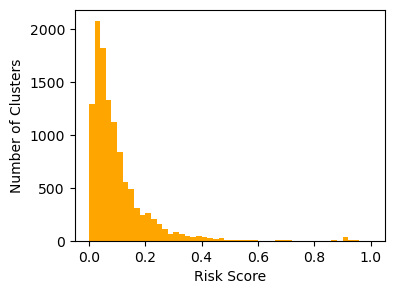

In [22]:
# Plot the distribution of Risk Scores

# Filter to focus on risk clusters (Risk Score > 0.5)
risk_clusters = cluster_risk_metrics_weighted[cluster_risk_metrics_weighted['Risk Score']>0.01]

plt.figure(figsize=(4, 3))
plt.hist(risk_clusters['Risk Score'], bins=50, range=(0, 1), color='orange')
plt.xlabel('Risk Score')
plt.ylabel('Number of Clusters')
# plt.title('Distribution of Risk Scores for High-Risk Clusters')
plt.savefig('cluster_risk_distribution.pdf', bbox_inches='tight')
plt.show()


**Save DataFrame**

In [188]:
# Save the updated DataFrame
cluster_risk_metrics_weighted.to_pickle('cluster_risk_metrics_pca.pkl')
print("Updated data saved to 'cluster_risk_metrics_pca.pkl'")



Updated data saved to 'cluster_risk_metrics_pca.pkl'


In [190]:
# Load Cluster Risk Metrics into DataFrame
cluster_risk_metrics_weighted = pd.read_pickle('cluster_risk_metrics_pca.pkl')
cluster_risk_metrics_weighted.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755,-0.072326
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709,-0.047453
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116


**Get Cluster Size from Database then Save File for Future Work**

In [50]:
# Query to get cluster sizes
cluster_sizes_query = f"""
MATCH (n)
WHERE n.communityId IS NOT NULL
RETURN n.communityId AS communityId, count(*) AS size
ORDER BY size DESC
"""
cluster_sizes = execute_query(cluster_sizes_query)
cluster_sizes_df = pd.DataFrame(cluster_sizes)
cluster_sizes_df.rename(columns={'communityId':'Community ID'}, inplace=True)

# Display
print("Top 10 Clusters by Size:")
print(cluster_sizes_df.head())

# Save DataFrame to a pickle file
cluster_sizes_df.to_pickle('cluster_sizes.pkl')

NameError: name 'execute_query' is not defined

**Merge Cluster Size with DataFrame**

In [192]:
# Load Previous Files 
cluster_total_metrics_temp = pd.read_pickle('cluster_risk_metrics_pca.pkl')
cluster_sizes_temp = pd.read_pickle('cluster_sizes.pkl')

# Merge Files and Save
cluster_total_metrics1 =  cluster_total_metrics_temp.merge(cluster_sizes_temp, on='Community ID', how='left')
cluster_total_metrics1.to_pickle('cluster_total_metrics1.pkl')
cluster_total_metrics1.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score,size
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755,-0.072326,20
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709,-0.047453,5
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,13
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,3
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,3


**Inter Cluster Connections**

In [469]:
# Query to analyze inter-cluster relationships
inter_cluster_query = f"""
MATCH (a)-[r]->(b)
WHERE a.communityId <> b.communityId
RETURN a.communityId AS sourceCluster, b.communityId AS targetCluster, count(*) AS connections
ORDER BY connections DESC
"""
inter_cluster_connections = execute_query(inter_cluster_query)
inter_cluster_df = pd.DataFrame(inter_cluster_connections)
inter_cluster_df.rename(columns={'sourceCluster':'Community ID'}, inplace=True)
inter_cluster_df.rename(columns={'targetCluster':'Target Cluster'}, inplace=True)

# Display
print("Top 10 Inter-Cluster Connections:")
print(inter_cluster_df.head())

# Save For Future Use
inter_cluster_df.to_pickle('inter_cluster_df.pkl')

Top 10 Inter-Cluster Connections:
   Community ID  Target Cluster  connections
0         48568           29418      1791786
1         29418           48568      1447774
2         34416           29418       837511
3         34416           28947       711388
4         29418           28947       699461


**Merge Cluster Connections with DataFrame**

In [194]:
# Load Previous Files
cluster_total_metrics_temp = pd.read_pickle('cluster_total_metrics1.pkl')
cluster_inter_connections = pd.read_pickle('inter_cluster_df.pkl')

# Merge and Save
cluster_total_metrics2 =  cluster_total_metrics_temp.merge(cluster_inter_connections, on='Community ID', how='left')
cluster_total_metrics2.to_pickle('cluster_total_metrics2.pkl')
cluster_total_metrics2.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score,size,Target Cluster,connections
0,0,NaN,NaN,0.0,0.0,31.300386,0.0,0.003755,-0.072326,20,NaN,NaN
1,1,NaN,NaN,0.0,0.0,195.021071,0.0,0.001709,-0.047453,5,NaN,NaN
2,2,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,13,NaN,NaN
3,3,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,3,NaN,NaN
4,4,NaN,NaN,0.0,0.0,0.000000,0.0,0.000000,-0.077116,3,NaN,NaN


**Export for saving and viewing**

In [130]:
# Load Pickle File
cluster_total_metrics2 = pd.read_pickle('cluster_total_metrics2.pkl')

In [198]:
# Sort the DataFrame by the 'Risk Score' column in descending order
cluster_metrics_sorted = cluster_metrics_final.sort_values(by='Risk Score', ascending=False)

# Display the top rows of the sorted DataFrame
cluster_metrics_sorted.head()

,Community ID,Total CVEs,Num_Releases,Average Severity Score,Normalized Total CVEs,Average Freshness (Days),Average Popularity,Average Speed (Days),Risk Score,size,Target Cluster,connections
39352,37666,2470.0,163.0,2.491498,15.153374,2028.301837,0.000000,0.045548,1.000000,179,NaN,NaN
45374,43639,1482.0,132.0,2.941970,11.227273,712.004092,0.000000,0.066108,0.802396,143,NaN,NaN
43632,41923,259.0,27.0,2.602317,9.592593,2044.736117,0.000000,0.010076,0.694845,29,NaN,NaN
11661,11268,71.0,8.0,2.000000,8.875000,914.076289,0.000000,0.008397,0.616346,12,NaN,NaN
30048,28947,827.0,292.0,2.585248,2.832192,878.906223,6.663125,0.100989,0.559408,561882,35373.0,24795.0


In [134]:
cluster_metrics_final.to_csv('cluster_metrics_final.csv', index=False)